# 5. Acoustic measurements

-----

In this final notebook we'll specify some of the **parameters that are widely used in acoustical measurements, more specifically in urban noise measurements, which is the main application of the developed device**.

We will call some of the functions introduced in the previous notebooks (which are included in `utils.py`) to obtain the different parameters, and **we'll develop new functionality to be able to easily calculate sound pressure levels with the device**.

## Sound pressure level

In acoustic measurements the variable that we're interested in is the instantaneous pressure, the dynamic variations in pressure around the atmospheric pressure. This value is **defined as the logarithmic relationship between this instantaneous pressure and the hearing threshold, which is about 20 μP**.

$$ SPL = 10 \log \left( \dfrac{P_{ef}^2}{\rho_0^2} \right) \ [dB_{SPL}] $$

$$ P_{ef} = \sqrt{ \dfrac{1}{T} \int_{o}^{T} p^2 (t) \ dt } $$

As we can see, $P_{ef}$ represents the RMS value of the instantaneous pressure.

## Integrating and averaging sound level meters

Since the instantaneous SPL will vary at every instant, we normally prefer to obtain a **measurement over a certain time interval, avearing the levels**. This can be obtained by either **exponential or linear averaging of the levels**. 

As we mentioned in the previous notebook the **sound level meters traditionally provided a way to ease the reading of levels by applying an RC integrating low-pass filter to the signal**.  The application of this procedure is known as **exponential averaging** of the sound pressure levels and the type of sound level meters that perform this operation are known as **averaging meters**. The exponential component is introduced to the SPL calculation as seen below.

$$ P_\tau = \sqrt{ \dfrac{1}{\tau} \int_{0}^{t} p^2 ( \theta ) \ e ^{ - \dfrac{t-\theta}{\tau}  } \  d\theta } $$

**Three time constants are used: Slow ($\tau$ = 1 s), Fast ($\tau$ = 125 ms) and Impulse ($\tau$ = 35 ms)**.

In the thesis we developed an **integrating-averaging meter**, which means that it can also linearly integrate the levels. These allow to obtain the **equivalent-continuous sound level, $L_{eq}$**. This is, **a constant value that represents a certain soubd pressure level which for some interval _T_ has the same amount of energy than the measured signal**. Its definition is as follows:

$$ L_{eq,T} = 10 \log \dfrac{1}{T} \int_{0}^{T} \dfrac{p^2 (t) \ dt}{p_0^2} $$

In urban noise measurement the **$L_{A,eq}$** is perhaps the most widely used indicator, where the **average levels are based on the integration of A frequency-weighted levels**.

Next we will generate a random array representing **individual sound pressure levels measured at 1 s intervals for 5 minute** and we will **calculate the $L_{eq}$ for the entire period**. The calculation will be based by combining the first and last equations above (which we'll purpousefully not state because who wants to see more than three equations on a Jupyter notebook).

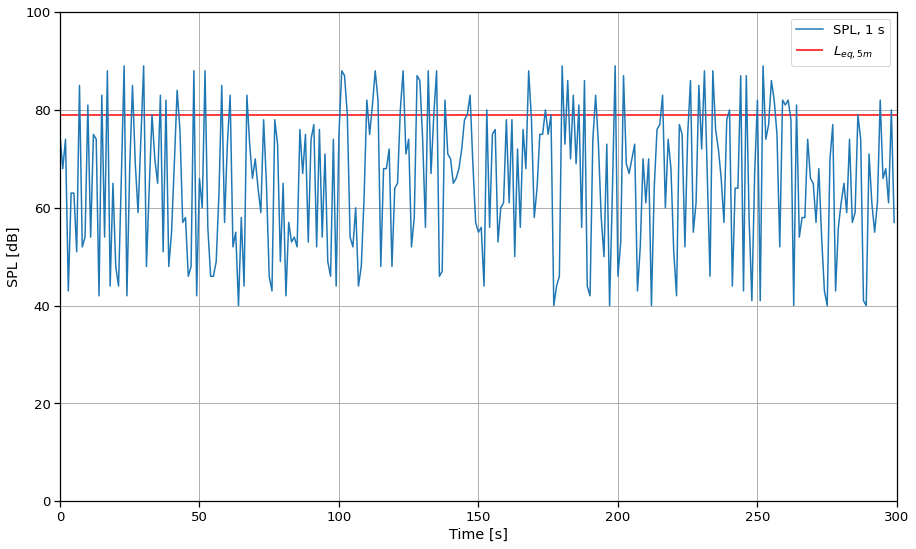

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (15,9)
sns.set_context('notebook', font_scale=1.2)

# Sampling frequency
FS = 48000

levels = np.random.randint(low=40, high=90, size=5*60)
leq = 10*np.log10(1/len(levels) * np.sum([10**(l/10) for l in levels]))

plt.plot(range(len(levels)), levels, label='SPL, 1 s')
plt.hlines(leq, 0, len(levels), color='r', label='$L_{eq, 5 m}$')

plt.xlabel('Time [s]')
plt.ylabel('SPL [dB]')
plt.xlim([0, 5*60])
plt.ylim([0, 100])
plt.legend()
plt.grid('on');

**The red line in the plot above, at the stated 5 minutes interval, has the same energy than the continuously variating SPL**. 

So, great we know what the **$L_{eq}$** represents and might have understood what makes this indicator important, easy to understand and widely used in acoustic measurements. But, how can we state this (or other) indicators with out developed device?

## Performing acoustic measurements

When doing a field measurement with a sound level meter, it is fundamental to **perform a calibration of this device agains a know acoustic source of known level and with a low uncertainty**. This is done by using **acoustic calibrators that are coupled with the microphones capsule**. Normally a level of **94 $dB_{SPL}$ or 114 $dB_{SPL}$ is used for this**.

## Getting a calibration signal for the device

In the case of our device we cant couple it directly to an acoustic calibrator because, well, there is not one designed for the type of microphone employed. For this, another method was used in which **first, we calibrated a sound level meter with its own acoustic calibrator, and then put both its capsule and our device's microphone in close proximity. We then reproduced a 1 kHz@94 $dB_{SPL}$ in an acoustic source, and recorded it with the device while measuring its equivalent level with the calibrated meter**.

Next, we'll load this recording, calculate it's RMS level and compare it to the value stated by the sound level meter during this measurement. The signal (as expected) doesn't have an exact level of 94 $dB_{SPL}$ so we need to consider the value obtained. In the code cells we'll be importing the functionality developed in the previous notebooks.

In [2]:
from sys import path
import os

path_parent = os.path.dirname(os.getcwd())
path.append(path_parent + '\\src') 

# importing from our utils module
from utils import wavread, rms

# loading the calibration recording
fs, cal_wav = wavread('../aud/cal.wav')

# Calibration Leq as stated by the sound level meter
cal_l = 94.6 # dB

# Getting the RMS level for the calibration
# we'll leave of the first and last half second
cal_rms = rms(cal_wav[int(0.5*fs):int(-0.5*fs)])

With the RMS and the sound level meter's indicated $L_{eq}$ we can now do measurements with the device!

As an example measurment we'll load the field recording and calculate the **$L_{eqA,1s}$**.

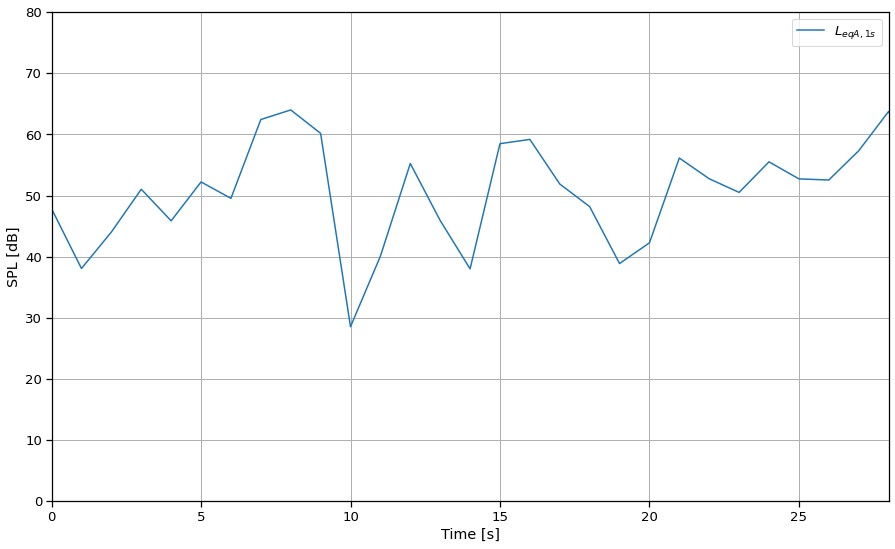

In [3]:
from utils import filt_A, rms_t

# loading
fs, field = wavread('../aud/field.wav')

# applying A-weighting filter
field_A = filt_A(field)

# getting the RMS levels per second
field_A_rms = rms_t(field_A, fs=fs)

# LeqA,1s
leqa = cal_l + 20*np.log10(field_A_rms/cal_rms)

plt.plot(range(len(leqa)), leqa, label='$L_{eqA, 1 s}$')

plt.xlabel('Time [s]')
plt.ylabel('SPL [dB]')
plt.xlim([0, 28])
plt.ylim([0, 80])
plt.legend()
plt.grid('on');

Yay! Now we can successfully measure levels by using the data from the calibration measurement. To wrap up we'll define other important parameters that have also an extended use in acoustical measurements.

## Day-evening-night noise level

The **$L_{den}$, day–evening–night noise level provides a way to express the level during the day as a single value**. It was introduced in the Directive 2002/49/CE European standard. In the equation below we can see that these parameter establishes **penalties for night and evening noise levels, for the higher annoyance it causes and the help problems associated with it.

$$ L_{den} = 10 \log \left[ \dfrac{1}{24} \ \left( 12 \cdot 10^{\dfrac{L_d}{10}} + 4 \cdot 10^\dfrac{L_e + 5}{10} + 8 \cdot 10^\dfrac{Ln + 10}{6} \right) \right]$$

## Percentile statistics

The statistical noise levels are commonly used for environmental noise monitoring, as they help to make sense of the **fluctuation of noise levels during the day**. The **$L_N$ statistical percentile is defined as the SPL value that is excedeed in a _N%_ of the measurement interval**. The higher is $N$, the lower $L_N$ gets.

The **$L_{90}$** and the **$L_{10}$** are used as a good representations of the overall **minimum and maximum values** respectively. The difference between both is know as **Noise Climate ($NC$)**, that indicates the **range of variation of the measured noise**.

## Station Leq measurement analysis and visualization

We're now going to import one of the device's output files after measuring and processing a recording in which we obtain the **$L_{eq}$ in 1 second intervals**.

This measurement was further processed within the device and **extracted as a `.csv` file**, where the hour, minute and second of each level is specified for each row. This file represented these levels for a whole day, specifically June 12, 2020.

Let's load the file and show it first rows.

In [4]:
import pandas as pd

measured_leq = pd.read_csv('../src/measured_leq.csv')

measured_leq.head()

,Hour,Minute,Second,Leq1s
0,0,0,0,39.45
1,0,0,1,37.75
2,0,0,2,60.56
3,0,0,3,37.46
4,0,0,4,36.81


As expected, the recording starts at 0 hours 0 minutes and 0 seconds, and shows the equivalent sound pressure level at each second. Since the monitoring station's output format are not convenient for further processing, we'll **convert the given information in the first three columns to a single `datetime` column**.

This will ve done in two steps, first we'll **join the hour, minute and second values to a single `HH:MM:SS` formatted strings, adding zeros where necessary**. Once we've done that, we can **parse the string values as `datetime` objects**. 

In [5]:
from datetime import datetime

def join_dates(h, m, s):
    add_zero = lambda x: '0' + str(int(x)) \
        if len(str(int(x))) == 1 \
        else str(int(x))
    return add_zero(h) + ':' + \
           add_zero(m) + ':' + \
           add_zero(s)

# joining hour, minute and second columns
hh_mm_ss = measured_leq.apply(lambda x: 
                              join_dates(x[0], x[1], x[2]), axis=1)

# parsing string as datetime and creating a new DataFrame
df = pd.concat((hh_mm_ss.apply(lambda x: datetime.strptime(x, '%H:%M:%S')\
                               .replace(year=2020, month=6, day=12)),
              measured_leq.iloc[:, -1]), axis=1)

df.head()

,0,Leq1s
0,2020-06-12 00:00:00,39.45
1,2020-06-12 00:00:01,37.75
2,2020-06-12 00:00:02,60.56
3,2020-06-12 00:00:03,37.46
4,2020-06-12 00:00:04,36.81


Good! Now, let's set that new column as an index. This will make it easier to do calculations in `pandas` based on the give values.

In [6]:
df.set_index(0, inplace=True)

df.index.name = None

## Resampling the Leq values

In many cases we may want to lower the level of granularity by **calculating average values over a time period greater than a second** (which is the monitoring station's standard value of time-integration).

For that, we need to define a function to get the **energetic average of the levels, instead of obtaining arithmetic mean, for the values that fall between the new time-integration period**.

In [7]:
mean_db = lambda x: 10*np.log10(np.mean(10**(x/10)))

In this case, we'll get the **$L_{eq}$ values in 10 minutes intervals**. We'll apply the function created and obtain a new `DataFrame`.

In [8]:
df_10m = df.resample('10T').apply(mean_db)

df_10m.columns = ['Leq,10m[dBA]']
df_10m.head().round(2)

,"Leq,10m[dBA]"
2020-06-12 00:00:00,59.08
2020-06-12 00:10:00,53.91
2020-06-12 00:20:00,60.82
2020-06-12 00:30:00,52.70
2020-06-12 00:40:00,53.71


## Calculating the Lden and percentile statistics

To wrap-up we'll **calculate the day-evening-night equivalent noise level ($L_{den}$) and two of the percentile statistics values we defined previously, the $L_90$ and $L_{10}$**.

These values can all be calculated with the software developed for the acoustic monitoring station, but in this case we'll do the calculations in this notebook and show the obtained values.

In [9]:
lden_day = df.between_time('07:00', '19:00', 
                           include_end=False).apply(mean_db).values
lden_eve = df.between_time('19:00', '23:00', 
                           include_end=False).apply(mean_db).values
lden_nig = df.between_time('23:00', '07:00', 
                           include_end=False).apply(mean_db).values

lden_lden = 10*np.log10((12*(10**((lden_day)/10)) \
                         + 4*(10**((lden_eve + 5)/10)) \
                         + 8*(10**((lden_nig + 10)/10)))/24)

df_q = df.quantile([0.1, 0.9])

print('Calculated levels:\n' + 20*('-'))
print(f'Ld: {lden_day[0]:.1f} dBA')
print(f'Le: {lden_eve[0]:.1f} dBA')
print(f'Ln: {lden_nig[0]:.1f} dBA')
print(f'Lden: {lden_lden[0]:.1f} dBA\n')
print(f'L90: {df_q.iloc[0].values[0]:.1f} dBA')
print(f'L10: {df_q.iloc[1].values[0]:.1f} dBA')

Calculated levels:
--------------------
Ld: 61.9 dBA
Le: 66.4 dBA
Ln: 61.0 dBA
Lden: 68.6 dBA

L90: 40.4 dBA
L10: 64.1 dBA


## Plotting the calculated values

Finally, we'll **plot the $L_{eq,10min}$ values alongside the calculated $L_{den}$ and the $L_{90}$ and $L_{10}$**.

We'll be changing the plot style for the one that GUI designed for the device uses. We'll limit the plot value to those corresponding to the **day period**, that is, between 7 hs. and 19 hs.

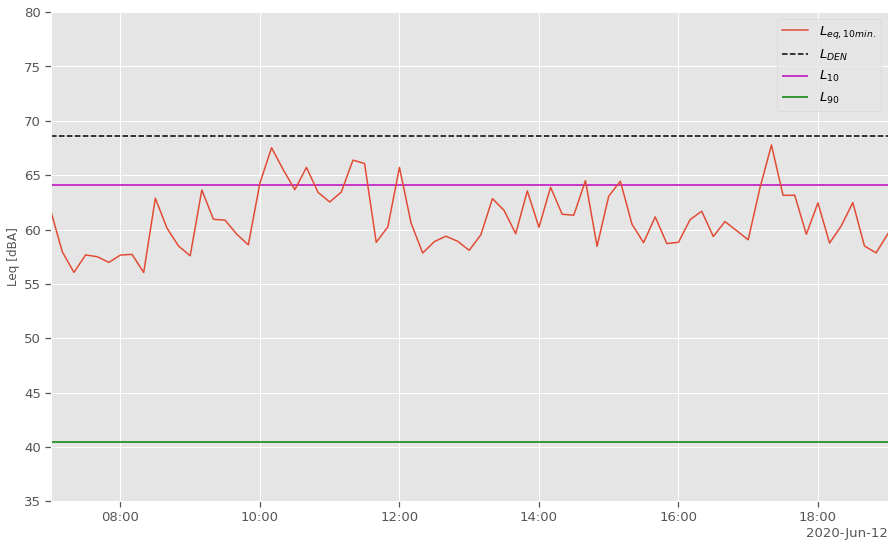

In [10]:
import matplotlib.dates as mdates
plt.style.use('ggplot')

# setting locator and formatter
pd.plotting.register_matplotlib_converters()
locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)

fig, ax = plt.subplots()

# plotting leq values
ax.plot(df_10m, label='$L_{eq,10min.}$')

xmin = datetime(2020, 6, 12, 7)
xmax = datetime(2020, 6, 12, 19)

ax.hlines(lden_lden, xmin, xmax, 'k', '--', label='$L_{DEN}$')
ax.hlines(df_q.iloc[1], xmin, xmax, 'm', label='$L_{10}$')
ax.hlines(df_q.iloc[0], xmin, xmax, 'g', label='$L_{90}$')

ax.set_ylim([35, 80])
ax.set_xlim([xmin, xmax])
ax.set_ylabel('Leq [dBA]')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.legend(loc='upper right');

## Conclusions

In this series of notebooks we went through almost all of the functionality included in the acoustic monitoring station's prototype that was designed as my thesis project. We could successfully recreate step by step what was developed in these Jupyter Notebooks.

The key takeaway is that we could build **software that translates the traditional capabilities of sound-level-meters in a digital and low-cost device**. This device can perform **urban noise measurements in an autonomous, continuous and remote manner**.

In this last notebook we stated the **differences between integrating and averaging sound level meters**, we defined the method chosen to perform the **device calibration**, and we introduced and calculated some of the **most relevant parameters used in urban noise measurements**: **the day-evening-night noise level**, and the **percentile statistics**.

From the last plot we can see **how the $L_{den}$ represents a single value for the levels registered throughout the day**. In this case, since the measurement was carried out in a busy intersection with regular coming and going bussess and vehicular traffic, the noise levels in the evening and night periods are similar to those in the day period, **the obtained value is higher than highest $L_{eq,10min.}$ measured**.

We can clearly see why the **$L_{90}$ is useful for representing the maximum level**, since it leaves out the highest peaks. The **$L_{10}$ is out of the range of the 10 minute equivalent levels, since it follows the lowest obtained values measured at 1 second**, which were re-averaged when we integrated for the new interval.

**Thanks for coming along for the ride!**